In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon

sns.set_style("whitegrid")

### Read in samples for origin ARS316, to set up the annotation of the nucleosome areas

## Wildtype

In [2]:
load_dir =  "ARS316"

In [3]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS316_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS316_end_LexA.txt")

## Divide the locus into a number of windows with fixed sizes to test for differences in methylation levels

In [4]:
windowsize = 30

d = {"pos_start":list(range(0, wt_rep3.shape[1], windowsize)),
            "pos_stop":list(range((windowsize -1) , wt_rep3.shape[1], windowsize)) + [wt_rep3.shape[1]]}
anno = pd.DataFrame(d,
            index = list(range(1, wt_rep3.shape[1]//windowsize + 2)))
anno["length"] = (anno.pos_stop +1) - anno.pos_start

anno["position"] = "x"

anno.head()

,pos_start,pos_stop,length,position
1,0,29,30,x
2,30,59,30,x
3,60,89,30,x
4,90,119,30,x
5,120,149,30,x


In [5]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS316_end_LexA_minus.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS316_end_LexA_minus.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS316_end_LexA_minus.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS316_end_LexA_minus.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS316_end_LexA_minus.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS316_end_LexA_minus.txt")

In [6]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2_rev.shape[0], wt_rep2.shape[0])

True
True
780 819


In [7]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-1]), axis = 0)
#subsample wt_rep2_rev to 780 reads
wt_rep2_sub = subsample(wt_rep2, 780)
wt_rep2_join = np.concatenate((wt_rep2_sub, wt_rep2_rev[:, :-1]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

In [8]:
wt_rep2.shape

(1560, 1239)

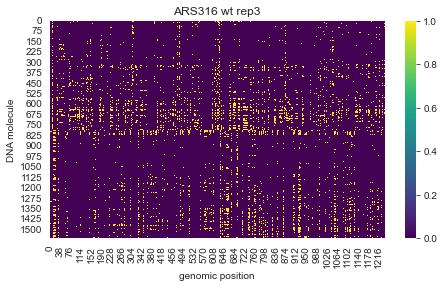

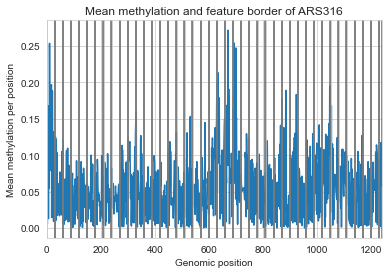

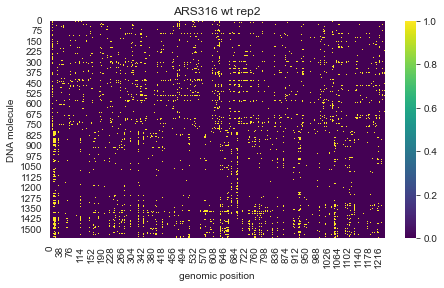

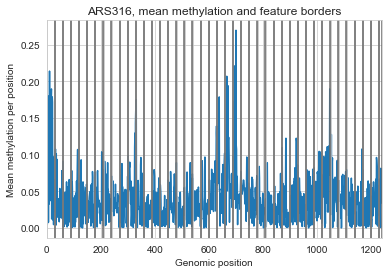

In [9]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep2")
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title(load_dir + ", mean methylation and feature borders")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

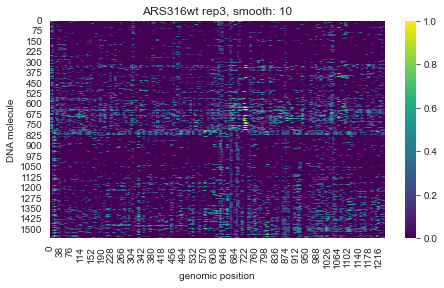

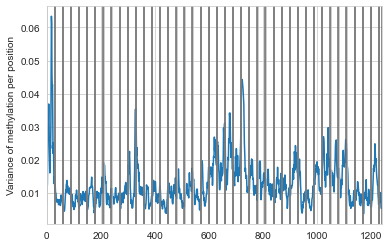

In [12]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 1, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

## Load data for mutant dies6

In [13]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS316_end_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape)

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS316_REP2_301READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape)

(83, 1239) (93, 1240)
(301, 1239) (274, 1240)


In [14]:
#subsample to equal read counts and join the plus and minus strand
dies6_rep1_rev_sub = subsample(dies6_rep1_rev, 83)
dies6_rep2_sub = subsample(dies6_rep2, 274)

dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev_sub[:, :-1]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2_sub, dies6_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

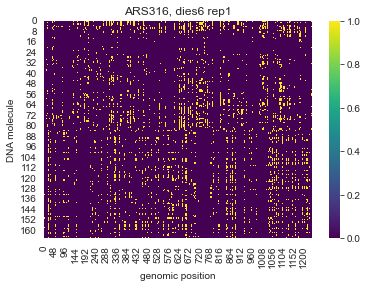

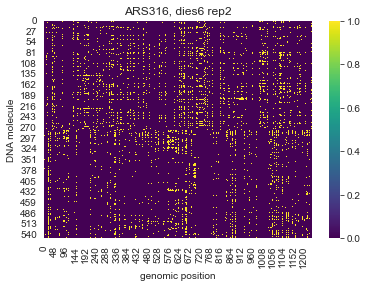

In [15]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()



sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

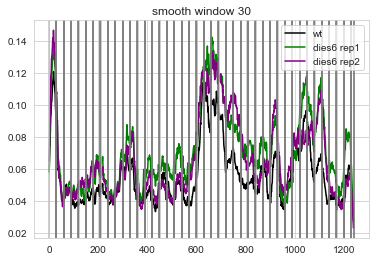

In [17]:
smooth_window=30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)


## Load data for mutant disw2

In [18]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS316_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)


disw2_rep2 = np.genfromtxt(load_dir + "/ARS316_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1239) (780, 1240)
(780, 1239) (780, 1240)


In [19]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-1]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-1]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

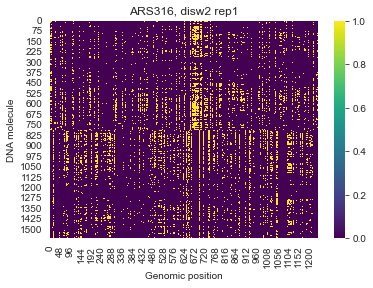

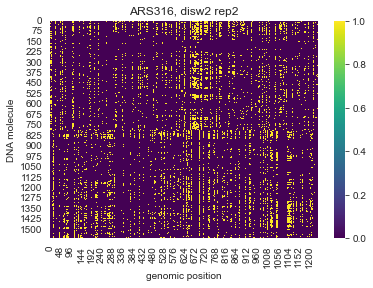

In [20]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()

sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

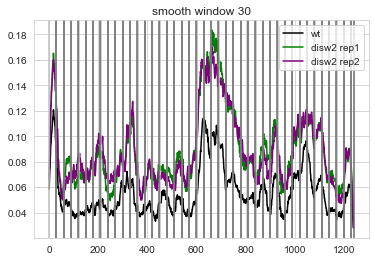

In [21]:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [22]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1239.0,0.056345,0.041711,0.0,0.025641,0.050000,0.078846,0.271795,1560
wt_rep2,1239.0,0.041150,0.034459,0.0,0.016987,0.033974,0.056410,0.269872,1560
dies6_rep1,1239.0,0.071720,0.061113,0.0,0.018072,0.066265,0.102410,0.397590,166
dies6_rep2,1239.0,0.067093,0.057521,0.0,0.014599,0.060219,0.098540,0.354015,548
disw2_rep1,1239.0,0.089074,0.073555,0.0,0.014744,0.084615,0.133013,0.405128,1560
disw2_rep2,1239.0,0.088250,0.070435,0.0,0.022436,0.082051,0.128205,0.397436,1560


### Normalise each experiment to the methylation level of the spike-in control and pool replicates

In [23]:
#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

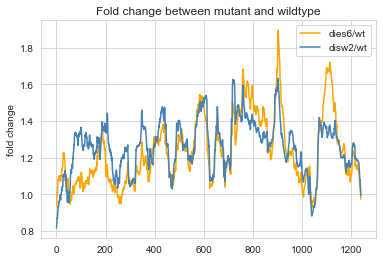

In [25]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
plt.show()

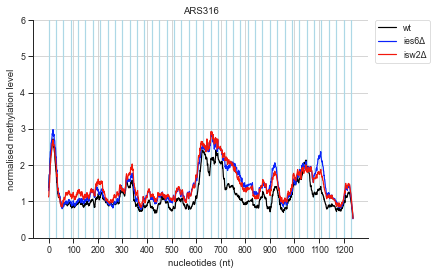

In [26]:
#For the fixed window sizes, plot the smoothened tracks and the start of each window
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False, 
                             "font_scale": 0.6}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window50.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Condense segment information for statistical testing of methylation per feature window for pooled replicates

In [27]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [28]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [29]:
segments#.head(n=15)
#segments.to_csv(load_dir + "/ARS316_pooled_samples_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.482209,0.770353
2,30,59,30,0.284462,0.442711
3,60,89,30,0.837244,0.000442
4,90,119,30,0.626597,0.045484
5,120,149,30,0.190804,0.000975
6,150,179,30,0.055664,0.005107
7,180,209,30,0.006232,0.003390
8,210,239,30,0.247337,0.016878
9,240,269,30,0.974125,0.294305
10,270,299,30,0.247337,0.002061


In [30]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation mutants compared to wildtype?")
print("       P-value below: ", pvalue)
significant = segments.loc[(segments["p_value_dies6"] < pvalue) | (segments["p_value_disw2"] < pvalue)]
significant

       Which sites have a different mean methylation mutants compared to wildtype?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
3,60,89,30,0.837244,0.000442
5,120,149,30,0.190804,0.000975
6,150,179,30,0.055664,0.005107
7,180,209,30,0.006232,0.003390
8,210,239,30,0.247337,0.016878
10,270,299,30,0.247337,0.002061
12,330,359,30,0.001426,0.000005
14,390,419,30,0.000161,0.000035
15,420,449,30,0.000227,0.000247
17,480,509,30,0.003390,0.003634


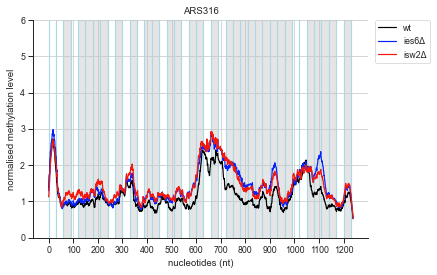

In [32]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS316_smoothed_profiles_revision_window100_selection.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

### Display the mean methylation per feature

In [33]:
def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        #means_by_feature = np.apply_along_axis(np.std, 1, feature_array) #to calculate variance
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [40]:
# for the fixed window size approach, only select significantly different regions
saved = anno.copy()
anno = anno.iloc[anno.index.intersection(significant.index)-1,:]

In [42]:
#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls

#normalise to the nucleosomal array spike-ins

wt_rep3_maxnorm = wt_rep3/mean_array_wt_rep3
wt_rep2_maxnorm = wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


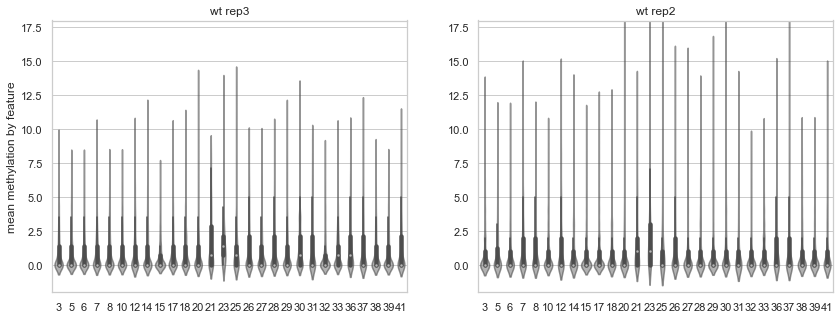

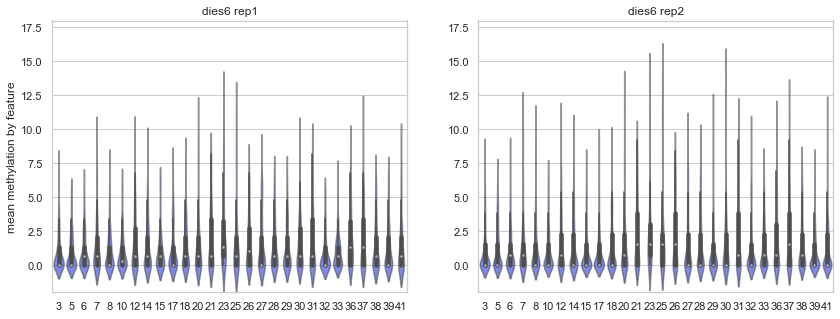

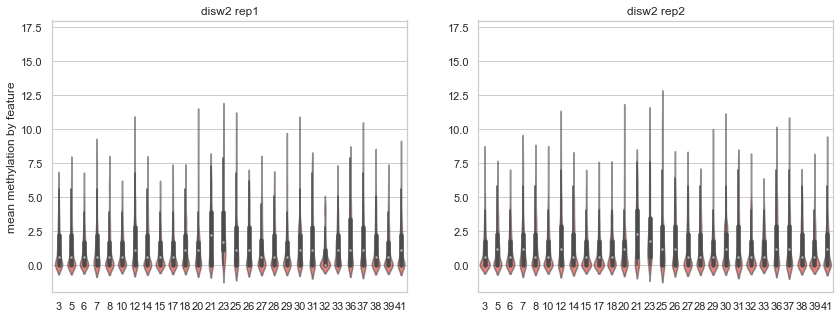

In [43]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_wt_revision.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_dies6_revision.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS316_methylyation_by_feature_disw2_revision.tif")
plt.show()

In [44]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "ies6Δ"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "isw2Δ"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

In [45]:
sns.set_context("paper")

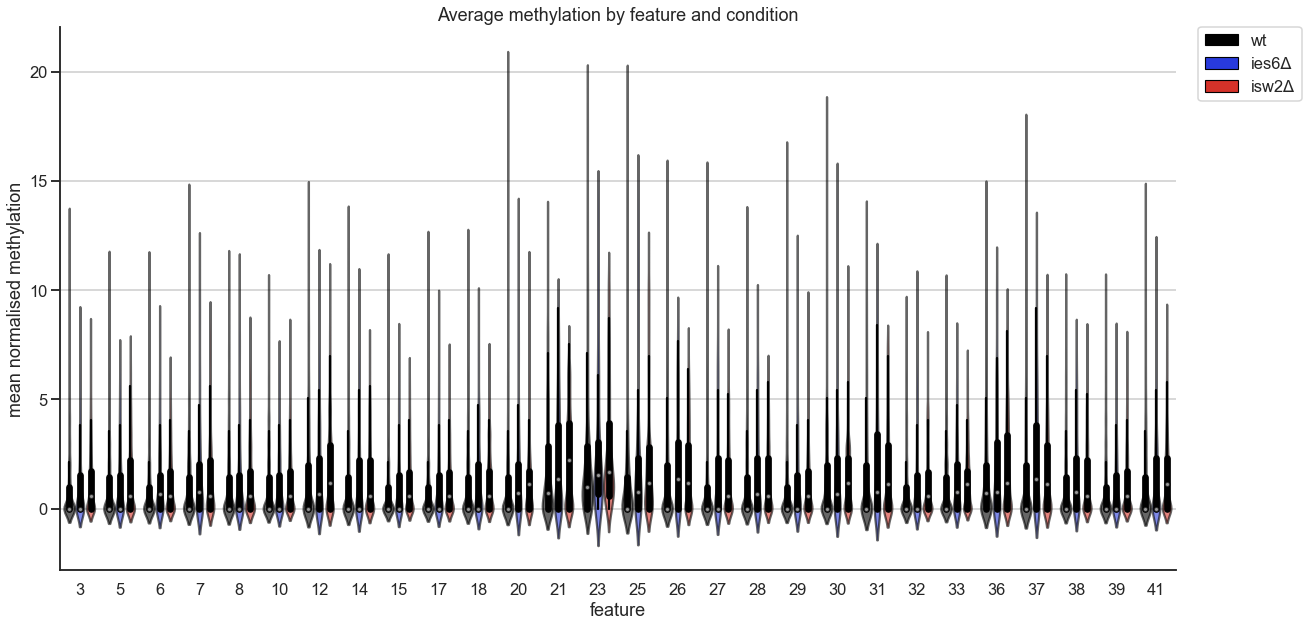

In [46]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False,
                                 'xtick.bottom': False}):
    sns.set_context("talk")
    plt.figure(figsize = (20,10)) #10,7
    ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.setp(ax.collections, alpha = 0.6)
    plt.title("Average methylation by feature and condition")
    plt.ylabel("mean normalised methylation")
    #plt.savefig(load_dir + "/plots/ARS316_pooled_norm_av_methylation_by_feature_window_30_union_revision.svg", 
     #           dpi = 300, bbox_inches = "tight")
    plt.show()

In [47]:
#methylation_rep1.to_csv(load_dir + "/ARS316_violinplots_annotation_v3.csv")

In [48]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "dies6"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "disw2"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

#methylation_features.to_csv(load_dir + "/ARS316_feature_methylation_annotation_v3.csv")

In [49]:
#methylation_features.to_csv(load_dir + "/ARS316_feature_methylation_window30_union_selected.csv")

In [50]:
from scipy.stats import mannwhitneyu

In [51]:
feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand")) ]


In [52]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand")) ]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_rep2,disw2_rep1
3,60,89,30,3.549524e-02,2.633695e-44
5,120,149,30,1.574294e-06,5.738462e-25
6,150,179,30,1.111171e-07,5.572071e-25
7,180,209,30,9.998789e-06,9.820635e-19
8,210,239,30,1.046001e-02,2.122799e-07
10,270,299,30,6.954337e-04,2.432485e-25
12,330,359,30,1.087566e-06,9.574436e-33
14,390,419,30,2.057040e-04,3.533848e-28
15,420,449,30,1.323873e-04,4.302237e-42
17,480,509,30,4.348553e-03,4.272780e-28


In [53]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not ((column == "molecule")|(column == "strand"))]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
3,60,89,30,2.950752e-02,1.947676e-44
5,120,149,30,3.335829e-06,4.045457e-46
6,150,179,30,6.118050e-08,3.509803e-42
7,180,209,30,6.108291e-06,2.994965e-34
8,210,239,30,7.017719e-03,9.679935e-22
10,270,299,30,5.680470e-04,6.059855e-34
12,330,359,30,2.145239e-07,3.915325e-53
14,390,419,30,1.393322e-06,5.010042e-45
15,420,449,30,4.278545e-07,4.262264e-58
17,480,509,30,1.080277e-03,1.818566e-32


In [68]:
#feature_pvalues.to_csv(load_dir + "/ARS316_p_values_avg_feature_methylation.csv")

## Use peak detection to estimate the size of the nucleosome-free region

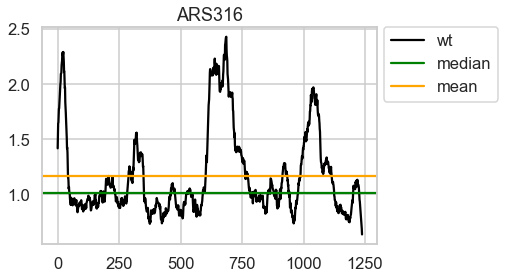

In [54]:
N=40
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

### Characterize peaks of the entire origin

In [55]:
from scipy import signal

x = pooled_wt_smoothed#[500:830]
peaks, properties = signal.find_peaks(x, width=20, 
                               rel_height=0.9,
                               #prominence = (None, 0.8), 
                               height= np.median(x)
                              )

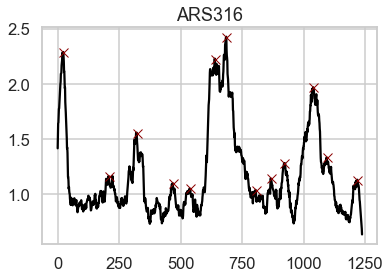

In [56]:
sns.set_context("talk")
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.title(load_dir)
plt.show()

In [57]:
print(properties["peak_heights"].mean(axis=0))
print(properties["prominences"].mean(axis=0))

1.5189710033661248
0.5447146109865371


### Measure the peak width of the nucleosome-free region (which is more central)

In [58]:
N=30
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

x = pooled_wt_smoothed[500:830]
peaks, properties = signal.find_peaks(x, width=20, 
                                      prominence = (0.8, None),
                                      height= np.mean(x),
                                      rel_height = 0.9
                              )

properties

{'peak_heights': array([2.4182186]),
 'prominences': array([1.51382471]),
 'left_bases': array([0]),
 'right_bases': array([299]),
 'widths': array([180.00514209]),
 'width_heights': array([1.05577636]),
 'left_ips': array([97.77526387]),
 'right_ips': array([277.78040597])}

In [59]:
signal.peak_widths(x, peaks, rel_height = 0.9)[0]

array([180.00514209])

Text(0.5, 1.0, 'Measure peak width at 90% rel height, ARS316')

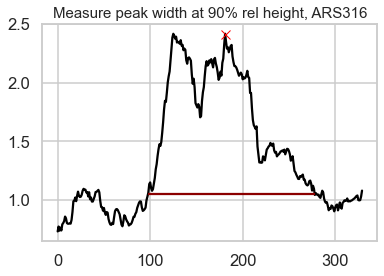

In [60]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS316", fontsize = 15)

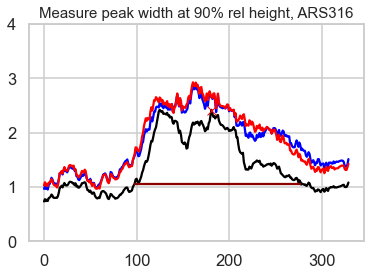

In [61]:
plt.plot(x, color = "black")
plt.plot(np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[500:830],
         color = "blue")
plt.plot(np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[500:830],
         color = "red")

plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS316", fontsize = 15)
plt.ylim(0,4)
plt.show()

### Define the width of the nucleosome-free region as P10 - the peak width at 10% of peak height, from the wild type sample. This represents the cutoff for this origin for "nucleosome free"

In [62]:
width = signal.peak_widths(x, peaks, rel_height = 0.9)

In [63]:
pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[560:950]
pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[560:950]

In [64]:
pooled_dies6_smoothed > width[1]

#so peak width =
width_dies6 = len(pooled_dies6_smoothed) -11 -7

In [65]:
#peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
#width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
print("peak width for dies6: ", width_dies6)

peak width for dies6:  372


In [66]:
pooled_disw2_smoothed > width[1] # first 2 values and last 6 values are not part of the peak
#so peak width = 
width_disw2 = len(pooled_disw2_smoothed) - 8

In [67]:
#peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
#width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
print("peak width for disw2: ", width_disw2)

peak width for disw2:  382


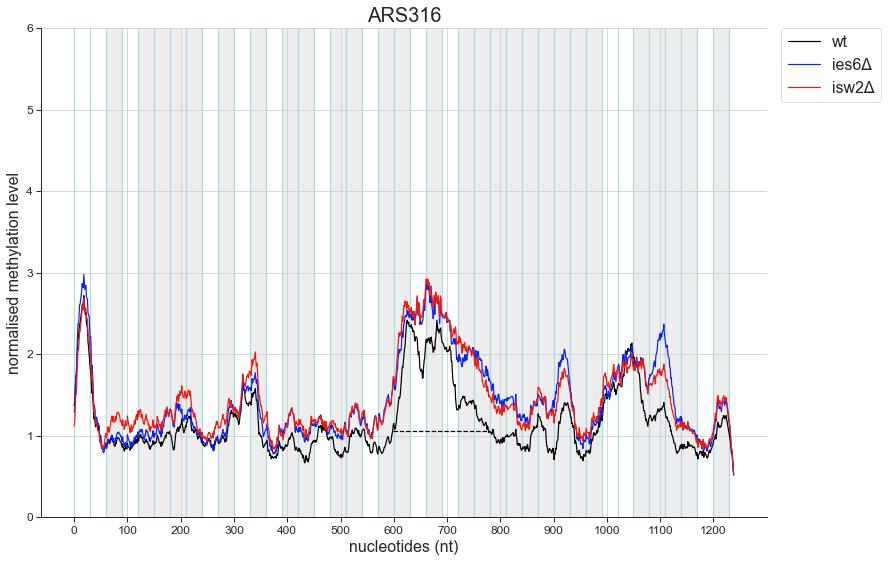

In [68]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        for left_border in saved.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "lightgray", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel("nucleotides (nt)", fontsize = 16)
        plt.ylabel("normalised methylation level", fontsize = 16)
        
        plt.hlines(y=signal.peak_widths(x, peaks, rel_height = 0.9)[1], # properties["width_heights"],
                   xmin=width[2]+500,
                   xmax=width[3]+500, 
                   color = "black", linestyles = "dashed")
        
        #plt.savefig(load_dir + "/plots/ARS316_smoothed_profiles_revision_window30_union_selection_peak_width.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Find valleys in normalised single-molecule data around the origin as footprints of Mcm double hexamers

In [69]:
# Concatenate normalised data from replicates 
wt_norm = np.concatenate((wt_rep3_maxnorm, wt_rep2_maxnorm), axis = 0)
dies6_norm = np.concatenate((dies6_rep1_maxnorm, dies6_rep2_maxnorm), axis =0)
disw2_norm = np.concatenate((disw2_rep1_maxnorm, disw2_rep2_maxnorm), axis =0)

In [70]:
def measure_valleys(array2D, width_range:tuple = (50,70)):
    #define dataframe to store peak information in 
    peak_sums = pd.DataFrame({"left_bases" : None,
                            "widths" : None} , 
                            index = range(array2D.shape[0]))
    
    for index, row in enumerate(array2D):
        _, peak_array = signal.find_peaks(-row, width= width_range) # only store peaks between 45 and 70 bases
        peak_sums.loc[index, "left_bases"] = list(peak_array["left_bases"])
        peak_sums.loc[index, "widths"] = list(peak_array["widths"])
    return peak_sums

In [71]:
def restore_valleys(peak_summary_df, output_shape:tuple):
    # define array of zeros in output shape, et regions of peaks to one
    zeros_array = np.zeros(output_shape)
    # loop over peak summary dataframe
    for row_num in range(peak_summary_df.shape[0]):
        #check if there are detected peaks for this molecule
        if peak_summary_df.loc[row_num, "widths"]:
            left_pos = peak_summary_df.loc[row_num, "left_bases"]
            widths = peak_summary_df.loc[row_num, "widths"]
            for ind, _ in enumerate(left_pos):
                zeros_array[row_num, left_pos[ind]: (left_pos[ind] + int(widths[ind]))] = 1
                #set stretches for peak width to 1
    return zeros_array

In [72]:
width_range = (140,160)
peaks_wt = measure_valleys(wt_norm, width_range = width_range) #[:, 450:750]
rebuild_wt = restore_valleys(peaks_wt, wt_norm.shape) #[:, 450:750]

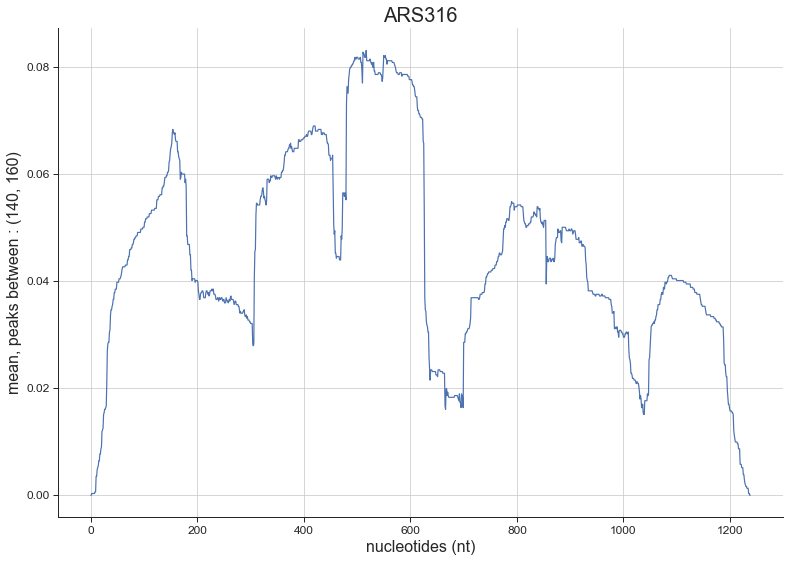

In [73]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.plot(rebuild_wt.mean(axis=0))
        plt.show()

In [74]:
peaks_dies6 = measure_valleys(dies6_norm, width_range = width_range) #[:, 450:750]
rebuild_dies6 = restore_valleys(peaks_dies6, dies6_norm.shape) #[:, 450:750]

peaks_disw2 = measure_valleys(disw2_norm, width_range = width_range) #[:, 450:750]
rebuild_disw2 = restore_valleys(peaks_disw2, disw2_norm.shape) #[:,380:700]

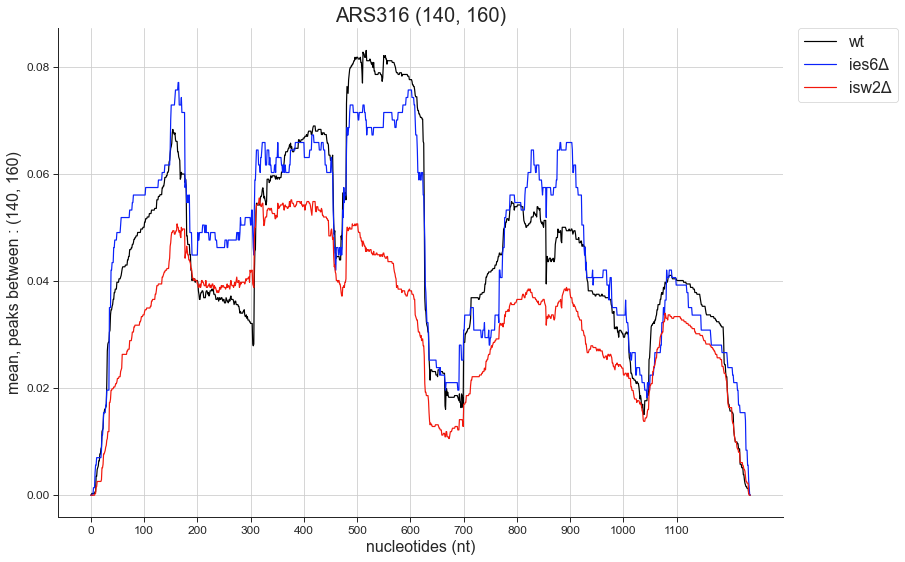

In [75]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        sns.lineplot(#x = range(450,750),
            x = range(wt_norm.shape[1]),
             y = rebuild_wt.mean(axis=0),
             color = "black", 
            label = "wt")
        sns.lineplot(#x = range(450,750),
            x = range(wt_norm.shape[1]),
             y = rebuild_dies6.mean(axis=0), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(#x = range(450,750),
            x = range(wt_norm.shape[1]),
            y = rebuild_disw2.mean(axis=0), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.xticks(range(0, 1200, 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir +" " + str(width_range), fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        
        plt.savefig(load_dir + "/plots/ARS316_distribution_peaks_140_160.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Plot the methylation frequency for the whole sequence of the origin:

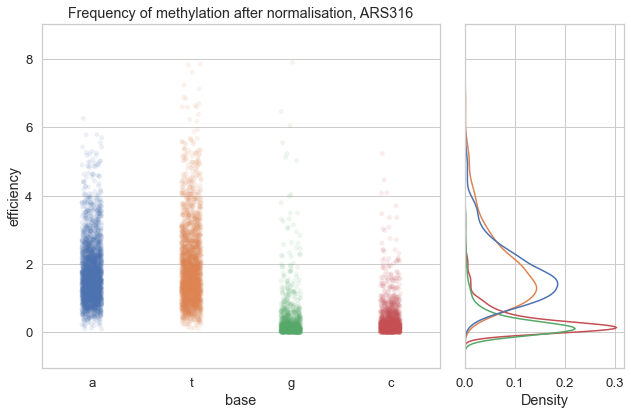

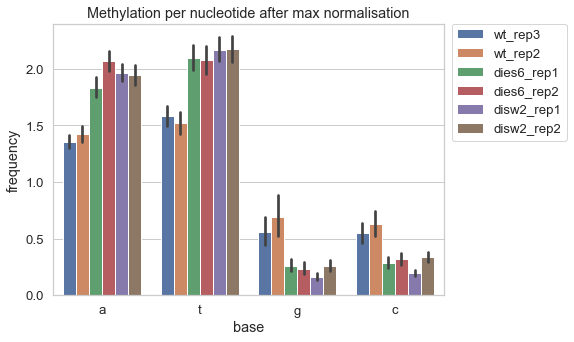

In [76]:
#prepare the data:

seq="atgaaagaatacgttattctttcatcaaatcgtggtcgaccggcatgcaagctccctcgagGTTGTCATCATAATCATACCATTCATTATCCTCTAGTTGGCATGACATTACTTTCCCCGAACTTAGAGAAACTTCAAACGTTATGGTGTCGGGATAAAATTTGATTAATTCACAACCTCTGCAATCAAGGCTTAAAGGAATGAAAGAATCTTCTTTGACCTTCGATAAACCATGCTTCTTCCGCACATCTTTTATCTTGGCCCATTTGTCGTCACTCTGATCAGTTAAATATTCATCCTCAAAAGCGCACAGGTTAACTGACAATTCTTTTGAACAAAATTTACACTTCATCAAGAAAGATGCGGTACCTTTTGATGCCGGCATAGCATATTCTTCAAATGTATTGATGATGACTTTAGAATCGTGTAATTCTCTACAACTGGTACATTGTAGATCGAAGGCAAATTCTGCCCTTGATTCGTTTGTATTCTCAATTGAAACCTTGGTCACGTTTTCTGATAATGTTGCTTTCAGAACCAAAAATAACGGCATTATCGTACACAACCTGGTTTTCTTTATTGGTTAAGTTGTCTTTATTCAAAATTTTTCATTACTTCTTATAAACAGCTTCTTGACGCTTGTAATTTCATAAGTTTTTGATACAAGCAATGGAAACAAAATTAAGAAAATGTAGGCAACGAAGAACTAAATTTGAAAAAAAAAAAAAAAAAAATTTACTGCCAAGATCATCTAAATTATCTTATAGTAGCAAAGCTTGAGCATAAAAGGATCAATCTTTTAGTTTTTTATGGCAAAGTACATTTGCAGTAAGTAATTAGTGATGAGATAAACAAAGAATAATAATCCAATTCGAAATCAAAAATTCAAACAACAAAAAACATAATTTCACATATATATCTAATTCATTCACGAAAAACACGTCAGTTCCTTCTGTCTGTTGTAAATAGGATGCATCCGCAGTGAATCATGGAAATATTTCAAAACTTTCAGCCCAATCATTTTATTTGGTCAATGAAGCCATAAACGCTCCGTAATTCTAAGATTAAAAAAAATTCATAAAAATAAGGACCAATATAAATATATATATTTAATGTGCTAGTGACAATCCTAGTGATAAAATTGCAAATTATACTACAATTGGTCATGGTGAAGCCTAAACACACCATTACGTCTTCACAGTGTTATTCATTTTATTTTCAAAGGTATGCTACTACTAA"
seq=seq.lower()
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1239))

eff_df["base"] = [letter for letter in seq]
eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS316")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide after max normalisation")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()